SQL data types generally fall into these three categories you’ll encounter most:
* **Characters** Any character or symbol
* **Numbers** Includes whole numbers and fractions
* **Dates and times** Temporal information

# Understanding Characters

**Character string types** are general-purpose types suitable for any combination of text, numbers, and symbols. 

Character types include the following:

**`char(n)`**:
* A fixed-length column where the character length is specified by `n`.
* A column set at `char(20)` stores 20 characters per row regardless of how many characters you insert.
* If you insert fewer than 20 characters in any row, PostgreSQL pads the rest of that column with spaces.

**`varchar(n)`**:
* A variable-length column where the maximum length is specified by `n`.
* If you insert fewer characters than the maximum, PostgreSQL will not store extra spaces.
* In large databases, this practice saves considerable space.

**`text`**:
* A variable-length column of unlimited length.
* According to the PostgreSQL documentation, the longest possible character string you can store is about 1 gigabyte.

> Note:
> * You cannot perform math operations on numbers stored in a character column.
> * Store numbers as character types only when they represent codes, such as a US postal ZIP code.

**Character data types in action**

```
CREATE TABLE char_data_types (
    char_column char(10),
    varchar_column varchar(10),
    text_column text
);

INSERT INTO char_data_types
VALUES
    ('abc', 'abc', 'abc'),
    ('defghi', 'defghi', 'defghi');

COPY char_data_types TO 'C:\YourDirectory\typetest.txt'
WITH (FORMAT CSV, HEADER, DELIMITER '|');
```

Here we’re not specifying the names of the columns. If the **`VALUES`** statements match the number of columns in the table, the database will assume you’re inserting values in the order the column definitions were specified in the table.

Next, we use the PostgreSQL **`COPY`** keyword to export the data to a text file named **`typetest.txt`** in a directory you specify. 
* You’ll need to replace **`C:\YourDirectory\`** with the full path to the directory on your computer where you want to save the file.
* The directory must exist already; PostgreSQL won’t create it for you.

> Note:
> * On Linux, you may see a permission denied error when using COPY. That’s because PostgreSQL runs as the **`postgres`** user, which can’t read or write to another user’s directory.
> * One solution is to read or write from the system **`/tmp`** folder, accessible to all users.
> * Be cautious, because some configurations cause this directory to be emptied upon reboot.

In PostgreSQL, 
* **`COPY table_name FROM`** is the import function,
* **`COPY table_name TO`** is the export function.

The **`WITH`** keyword options will format the data in the file with each column separated by a pipe **(`|`)** character. That way, you can easily see where spaces fill out the unused portions of the char column.


To see the output, open **`typetest.txt`** using the text editor. The contents should look like this:

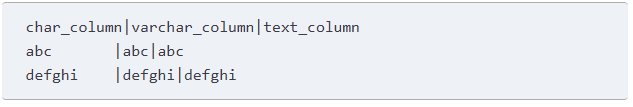

Even though you specified 10 characters for both the **`char`** and **`varchar`** columns, only the **`char`** column outputs 10 characters in both rows, padding unused characters with spaces. The **`varchar`** and **`text`** columns store only the characters you inserted.

Again, there’s no real performance difference among the three types, although this example shows that **`char`** can potentially consume more storage space than needed. A few unused spaces in each column might seem negligible, but multiply that over millions of rows in dozens of tables and you’ll soon wish you had been more economical.

I tend to use **`text`** on all my character columns. That saves me from having to configure maximum lengths for multiple **`varchar`** columns and means I won’t need to modify a table later if the requirements for a character column change.

# Understanding Numbers

Number columns hold various types of numbers, but that’s not all: they also allow you to perform calculations on those numbers. That’s an important distinction from numbers you store as strings in a character column, which can’t be added, multiplied, divided, or perform any other math operation. Also, numbers stored as characters sort differently than numbers stored as numbers, so if you’re doing math or the numeric order is important, use number types.

The SQL number types include the following:
* **Integers**: Whole numbers, both positive and negative
* **Fixed-point and floating-point**: Two formats of fractions of whole numbers

## Using Integers

* Integers are whole numbers, both positive and negative, including zero.
* The SQL standard provides three integer types: `smallint`, `integer`, and `bigint`.
* The difference between the three types is the maximum size of the numbers they can hold.

**Integer Data Types**

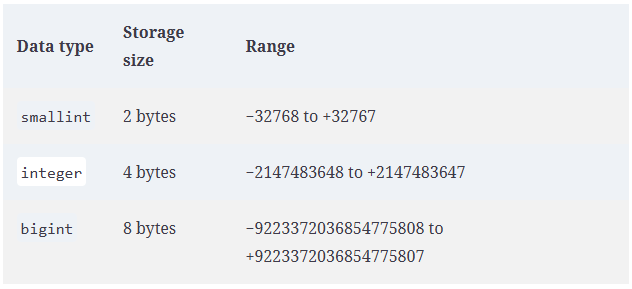

If you try to insert a number into any of these columns that is outside its range, the database will stop the operation and return an **`out of range`** error.

## Auto-Incrementing Integers

* With PostgreSQL, you have two ways to auto-increment an integer column.
* One is the **`serial`** data type, a PostgreSQL-specific implementation of the ANSI SQL standard for auto-numbered **identity** columns.
* The other is the ANSI SQL standard **`IDENTITY`** keyword.



### Auto-Incrementing with `serial`

**Serial Data Types**

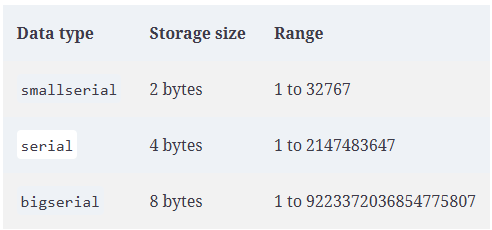

When you add a column with a **`serial`** type, PostgreSQL will auto-increment the value each time you insert a row, starting with **1**, up to the maximum of each integer type.

```
CREATE TABLE people (
    id serial,
    person_name varchar(100)
);
````

### Auto-Incrementing with `IDENTITY`

You can specify **`IDENTITY`** in two ways:

1. **`GENERATED ALWAYS AS IDENTITY`** tells the database to always fill the column with an auto-incremented value. A user cannot insert a value into the **`id`** column without manually overriding that setting. See the **`OVERRIDING SYSTEM VALUE`** section of the PostgreSQL **`INSERT`** documentation at **[https://www.postgresql.org/docs/current/sql-insert.html](https://www.postgresql.org/docs/current/sql-insert.html)** for details.

2. **`GENERATED BY DEFAULT AS IDENTITY`** tells the database to fill the column with an auto-incremented value by default if the user does not supply one. This option allows for the possibility of duplicate values, which can make use of it problematic for creating key columns.

```
CREATE TABLE people (
    id integer GENERATED ALWAYS AS IDENTITY,
    person_name varchar(100)
);
```

> **Note:** *Even though the value in an auto-incrementing column increases each time a row is added, some scenarios will create gaps in the sequence of numbers in the column. If a row is deleted, for example, the value in that row is never replaced. Or, if a row insert is aborted, the sequence for the column will still be incremented.*

## Using Decimal Numbers

* **Decimals** represent a whole number plus a fraction of a whole number; the fraction is represented by digits following a decimal point. 
* In a SQL database, they’re handled by **fixed-point** and **floating-point** data types.
* The only difference is how the computer stores the data.

### Understanding Fixed-Point Numbers

* The **fixed-point type**, also called the **arbitrary precision type**, is **`numeric(precision,scale)`**.
    * You give the argument **`precision`** as the maximum number of digits to the left and right of the decimal point.
    * And the argument **`scale`** as the number of digits allowable on the right of the decimal point.
* Alternately, you can specify this type using **`decimal(precision,scale)`**.
* Both are part of the ANSI SQL standard.
* If you omit specifying a **`scale`** value, the **`scale`** will be set to zero; in effect, that creates an integer.
* If you omit specifying the **`precision`** and the **`scale`**, the database will store values of any **`precision`** and **`scale`** up to the maximum allowed. (That’s up to **131,072** digits before the decimal point and **16,383** digits after the decimal point, according to the PostgreSQL documentation at **[https://www.postgresql.org/docs/current/datatype-numeric.html](https://www.postgresql.org/docs/current/datatype-numeric.html)**.)


**Example:**

To record rainfall in the database using five digits total (the **`precision`**) and two digits maximum to the right of the decimal (the **`scale`**), you’d specify it as **`numeric(5,2)`**. The database will always return two digits to the right of the decimal point, even if you don’t enter a number that contains two digits such as 1.47, 1.00, and 121.50.

### Understanding Floating-Point Types

* The two floating-point types are **`real`** and **`double precision`**, both part of the SQL standard.
* The difference between the two is how much data they store.
* The **`real`** type allows `precision` to six decimal digits, and **`double precision`** to 15 decimal digits of `precision`, both of which include the number of digits on both sides of the point.
* These floating-point types are also called **variable-precision types**.
* The database stores the number in parts representing the digits and an exponent—the location where the decimal point belongs.
* So, unlike **`numeric`**, where we specify fixed precision and scale, the decimal point in a given column can **“float”** depending on the number.

### Using Fixed- and Floating-Point Types

Each type has differing limits on the number of total digits, or precision, it can hold.

**Fixed-Point and Floating-Point Data Types**

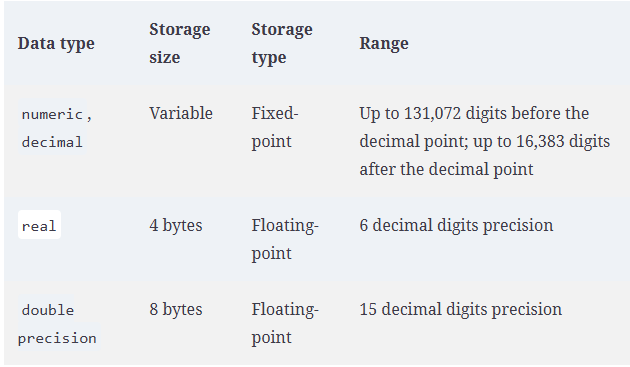

To see how each of the three data types handles the same numbers, create a small table and insert a variety of test cases.

```
CREATE TABLE number_data_types (
    numeric_column numeric(20,5),
    real_column real,
    double_column double precision
);

INSERT INTO number_data_types
VALUES
    (.7, .7, .7),
    (2.13579, 2.13579, 2.13579),
    (2.1357987654, 2.1357987654, 2.1357987654);

SELECT * FROM number_data_types;
```
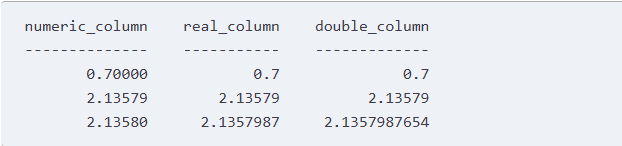

Notice what happened. The **`numeric`** column, set with a scale of five, stores five digits after the decimal point whether or not you inserted that many. If fewer than five, it pads the rest with zeros. If more than five, it rounds them—as with the third-row number with 10 digits after the decimal.

The **`real`** and **`double precision`** columns add no padding. On the third row, you see PostgreSQL’s default behavior in those two columns, which is to output floating-point numbers using their shortest precise decimal representation rather than show the entire value. Note that older versions of PostgreSQL may display slightly different results.

### Running into Trouble with Floating-Point Math

* If you’re thinking, ***“Well, numbers stored as a floating-point look just like numbers stored as fixed”***, tread cautiously. 
* The way computers store floating-point numbers can lead to unintended mathematical errors. 

```
SELECT
    numeric_column * 10000000 AS fixed,
    real_column * 10000000 AS floating
FROM number_data_types
WHERE numeric_column = .7;
```

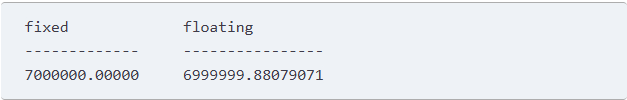


## Understanding Dates and Times

PostgreSQL’s date and time support includes the four major data types.

**Date and Time Data Types**

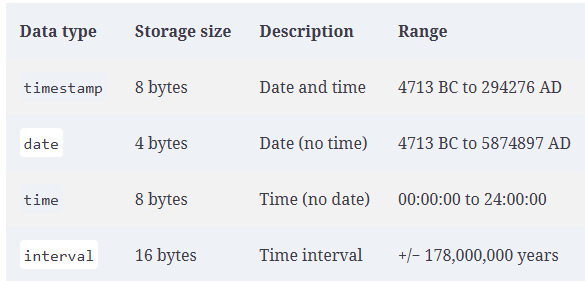

Let’s focus on the **`timestamp with time zone`** and **`interval`** types.

```
CREATE TABLE date_time_types (
    timestamp_column timestamp with time zone,
    interval_column interval
);

INSERT INTO date_time_types
VALUES
    ('2022-12-31 01:00 EST','2 days'),
    ('2022-12-31 01:00 -8','1 month'),
    ('2022-12-31 01:00 Australia/Melbourne','1 century'),
    (now(),'1 week');

SELECT * FROM date_time_types;
```

After the script runs, the output should look similar to (but not exactly like) this:

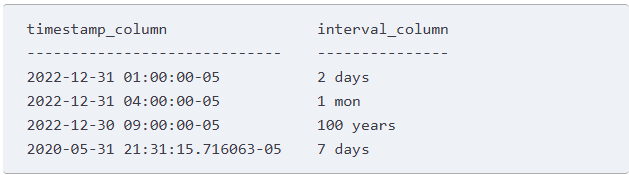

Even though we supplied the same date and time in the first three rows on the **`timestamp_column`**, each row’s output differs. The reason is that pgAdmin reports the date and time relative to my time zone, which in the results shown is indicated by the UTC offset of **`-05`** at the end of each timestamp. A UTC offset of **`-05`** means five hours behind UTC, equivalent to the US Eastern time zone during fall and winter months when standard time is observed. If you live in a different time zone, you’ll likely see a different offset; the times and dates also may differ from what’s shown here. We can change how PostgreSQL reports these timestamp values.

Finally, the **`interval_column`** shows the values you entered. PostgreSQL changed `1 century` to `100 years` and `1 week` to `7 days` because of its preferred default settings for interval display.

# Using the interval Data Type in Calculations

The **`interval`** data type is useful for easy-to-understand calculations on date and time data. For example, let’s say you have a column that holds the date a client signed a contract. Using **`interval`** data, you can add **90 days** to each contract date to determine when to follow up with the client.

To see how the **`interval`** data type works, we’ll use the date_time_types table.

```
SELECT
    timestamp_column,
    interval_column,
    timestamp_column - interval_column AS new_date
FROM date_time_types;
```
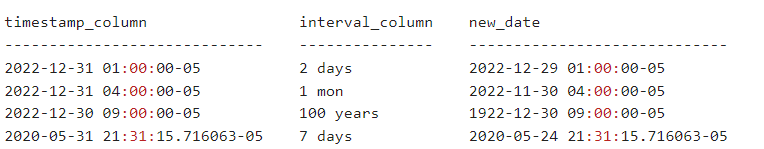

Note that the **`new_date`** column by default is formatted as type **`timestamp with time zone`**, allowing for the display of time values as well as dates if the interval value uses them. 
* You can see the data type listed in the pgAdmin results grid, listed beneath the column names.
* Again, your output may be different based on your time zone.

# Understanding JSON and JSONB

**JSON**, short for `JavaScript Object Notation`, is a structured data format used for both storing data and exchanging data between computer systems. All major programming languages support reading and writing data in JSON format, which organizes information in a collection of key/value pairs as well as lists of values. 

Here’s a simple example:

```
{
  "business_name": "Old Ebbitt Grill",
  "business_type": "Restaurant",
  "employees": 300,
  "address": {
    "street": "675 15th St NW",
    "city": "Washington",
    "state": "DC",
    "zip_code": "20005"
  }
}
```

PostgreSQL currently offers two data types for JSON, which both enforce valid JSON and support functions for working with data in that format:
* **`json`** Stores an exact copy of the JSON text
* **`jsonb`** Stores the JSON text in a binary format

There are significant differences between the two. For example, **`jsonb`** supports indexing, which can improve processing speed.

# Using Miscellaneous Types

**Character**, **number**, and **date/time** types will likely comprise the bulk of the work you do with SQL. But PostgreSQL supports many additional types, including but not limited to the following:
* A **Boolean type** that stores a value of `true` or `false`.
* **Geometric types** that include points, lines, circles, and other two-dimensional objects.
* **Text search types** for PostgreSQL’s full-text search engine.
* **Network address types**, such as IP or MAC addresses.
* A **universally unique identifier (UUID) type**, sometimes used as a unique key value in tables.
* **Range types**, which let you specify a range of values, such as integers or timestamps.
* **Types** for storing binary data.
* An **XML data type** that stores information in that structured format.

# Transforming Values from One Type to Another with CAST

Occasionally, you may need to transform a value from its stored data type to another type. 
* For example, you may want to retrieve a number as a character so you can combine it with text.
* Or you might need to convert dates stored as characters into an actual date type so you can sort them in date order or perform interval calculations.
* You can perform these conversions using the **`CAST()`** function.
* The **`CAST()`** function succeeds only when the target data type can accommodate the original value. 
* Casting an integer as text is possible because the character types can include numbers.
* Casting text with letters of the alphabet as a number is not.

**Three **`CAST()`** example**

Here are the three examples using the three data type tables. The first two examples work, but the third will try to perform an invalid type conversion so you can see what a type-casting error looks like.

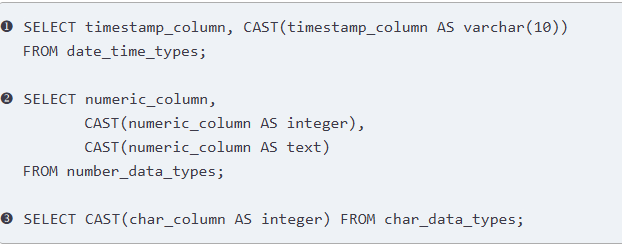

The final SELECT doesn’t work: it returns an error of invalid input syntax for type integer because letters can’t become integers!

# Using CAST Shortcut Notation

It’s always best to write SQL that can be read by another person who might pick it up later, and the way **`CAST()`** is written makes what you intended when you used it fairly obvious. However, PostgreSQL also offers a less obvious shortcut notation that takes less space: **the double colon**.

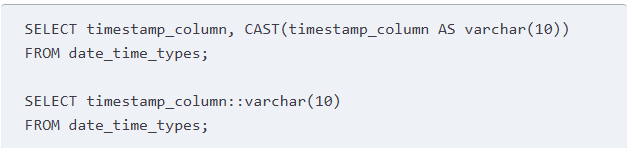

Use whichever suits you, but be aware that the double colon is a PostgreSQL-only implementation not found in other SQL variants, and so won’t port.